In [1]:
%%capture
!pip install tensorflow-datasets==4.8 --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install pydot --quiet
!pip install transformers==4.17 --quiet
!pip install -U scikit-learn

In [2]:
#Tensorflow libiries
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

#Transformers - BERT from huggingface
from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()
from transformers import AutoConfig
from tensorflow.keras.callbacks import EarlyStopping

#NLP libiries
import sklearn as sk
from sklearn.metrics import classification_report
import os
import nltk
from nltk.data import find

#data process
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
import pandas as pd
import math
from bs4 import BeautifulSoup
import os
import json


In [3]:
#loading the pre-trained tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

In [7]:
#load the dataset with error handling
try:
    train_df = pd.read_csv('2016_train_data(Revised).csv')
except pd.errors.ParserError as e:
    print(f"Error reading CSV: {e}")
    # Print the lines around the problematic row
    with open('2016_train_data(Revised).csv', 'r') as f:
        lines = f.readlines()
        for i in range(17622, 17626):
            if i < len(lines):
                print(lines[i])

test_df = pd.read_csv('2016_test_data(Revised).csv')

# Adjust pandas display settings to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full content of each column
pd.set_option('display.width', None)  # Auto-detect width of the display




In [8]:
train_df.head(1)

,title,date,content_original,bias,bias_text,source
0,"trump present dilemma evangelical women, reliable gop voter listen· 3:46",2016-11-01,"trump present dilemma evangelical women, reliable gop voter enlarge image toggle caption frank mullen/gettyimages frank mullen/gettyimages white evangelicals reliable republican voters. also long history demanding politician exemplify character morality public life. so many, republican presidential nominee donald trump present moral dilemma. trump apologized many saw one egregious moment — bragging groping kissing woman without consent 2005 recording. denied allegation several woman accusing sexual assault. but episode exposed another divide white evangelical community — split gender. several prominent male evangelical leader quick accept trump apology comments. called voter stay focused defeating democratic nominee hillary clinton. for evangelical women, like charmaine yoest protrump group american values, trump apology good start. i think situation like really cant overdo talking much understand people feeling — thats part leader, yoest says. for others, like katelyn beaty, editoratlarge christianity today, response evangelical leader exposed lack understanding. every church america woman member sitting pew every sunday deeply personal issue, beaty says. beatys magazine recently published editorial critical trump. speaking via skype, beaty pointed prominent evangelical writer like beth moore jen hatmaker whove recently called male leader quick dismiss whole thing. for many rankandfile women, sexual harassment assault personal issues, say susan fletcher colorado springs. i victim sexual harassment workplace; ive life made living hell person power me, says. fletcher, 30s, staff historian evangelical ministry. say rhetoric shes hearing recently around sexual assault disturbing many evangelical woman knows. you know, traditional, almost patriarchy older, white, evangelical men supporting endorsing — definitely huge disconnect theyre saying people like me, historian young woman, thinking feeling, fletcher says. christian singersongwriter nichole nordeman say usually stay politics, felt compelled speak year. nordeman point men, like southern baptist leader russell moore christian writer max lucado, speaking trump months. call response others devastating. i find sickening men face congregation family college campus feel ok trusting donald trump voice vote country — still somehow explain away lens teaching christ, nordeman says. boggles mind. baffling. nordeman say exciting time evangelical woman, think evangelicalism may turning point. in circle run in, keep hearing term xvangelical thrown around quite bit — sense trying find new language define u follower christ, old term felt unbelievably compromised election old guard evangelical leadership, nordeman says. beaty say there lot stake evangelical old guard address issue gender. they risk losing authority kind trust many evangelicals country, especially evangelical women, beaty says. beaty say rift highlighted politics 2016 likely continue long campaign over.",1,center,NPR Online News


In [ ]:
print(f"basic train_df info: ",train_df.shape)

In [ ]:
test_df.head(1)

In [ ]:
print(f"basic test_df info: ",test_df.shape)

In [9]:
# extract the train and test text from both dataframes
train_text = train_df['content_original']
train_text_labels = train_df['bias']

validate_text = test_df['content_original'][0:200]
validate_text_labels = test_df['bias'][0:200]

test_text = test_df['content_original'][200:]
test_text_labels = test_df['bias'][200:]


print(f"size of training dataset: ",len(train_text))
print()
print(f"size of valid dataset: ",len(validate_text))
print()
print(f"size of testing dataset: ",len(test_text))
print()
print(f"Left with Label 0 ")
print(f"Center with Label 1 ")
print(f"Right with Label 2 ")

size of training dataset:  2314

size of valid dataset:  200

size of testing dataset:  379

Left with Label 0 
Center with Label 1 
Right with Label 2 


In [10]:
MAX_SEQUENCE_LENGTH = 512

In [11]:
# tokenize the dataset, truncate at `max_length`,

#tokenizing the train text
x_train = bert_tokenizer(train_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_train = train_text_labels

#tokenizing the validate text
x_validate = bert_tokenizer(validate_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_validate = validate_text_labels


#tokenizing the test text
x_test = bert_tokenizer(test_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_test = test_text_labels

In [ ]:
# # tokenize the dataset, truncate at `max_length`,

# #tokenizing the train text
# x_train = bert_tokenizer(train_text.tolist(),
#               max_length=MAX_SEQUENCE_LENGTH,
#               truncation=True,
#               padding='max_length',
#               return_tensors='tf')
# y_train = train_text_labels

# #tokenizing the validate text
# x_validate = bert_tokenizer(validate_text.tolist(),
#               max_length=MAX_SEQUENCE_LENGTH,
#               truncation=True,
#               padding='max_length',
#               return_tensors='tf')
# y_validate = validate_text_labels


# #tokenizing the test text
# x_test = bert_tokenizer(test_text.tolist(),
#               max_length=MAX_SEQUENCE_LENGTH,
#               truncation=True,
#               padding='max_length',
#               return_tensors='tf')
# y_test = test_text_labels

In [12]:
#BERT base uncased model configurations
config = AutoConfig.from_pretrained('bert-base-uncased')

config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#BERT Uncase Model Fine-Tuning

In [13]:
def create_bert_classification_model(bert_model,
                                      num_train_layers=0,
                                      num_classes=3,
                                      num_filters=100,
                                      kernel_sizes=[3, 4, 5],
                                      hidden_size=768,
                                      dropout=0.35,
                                      attention_probs_dropout_prob=0.2,
                                      hidden_dropout_prob=0.25,
                                      learning_rate=0.00005):

    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask}
    bert_out = bert_model(bert_inputs)

    # Use the last hidden state (contextualized embeddings)
    sequence_output = bert_out[0]

    # CNN layers
    conv_layers = []
    for kernel_size in kernel_sizes:
        conv = tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(sequence_output)
        pooled = tf.keras.layers.GlobalMaxPooling1D()(conv)
        conv_layers.append(pooled)

    # Combine CNN outputs
    combined = tf.keras.layers.concatenate(conv_layers)

    # Dropout and fully connected layer
    hidden_1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_1')(combined)
    hidden_1 = tf.keras.layers.Dropout(dropout)(hidden_1)
    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(hidden_1)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')
    return classification_model

In [14]:
#let's get a fresh instance of the bert_model -- good practice
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_classification_model = create_bert_classification_model(bert_model, num_train_layers=12)

In [15]:
#confirm all layers are frozen
bert_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                      

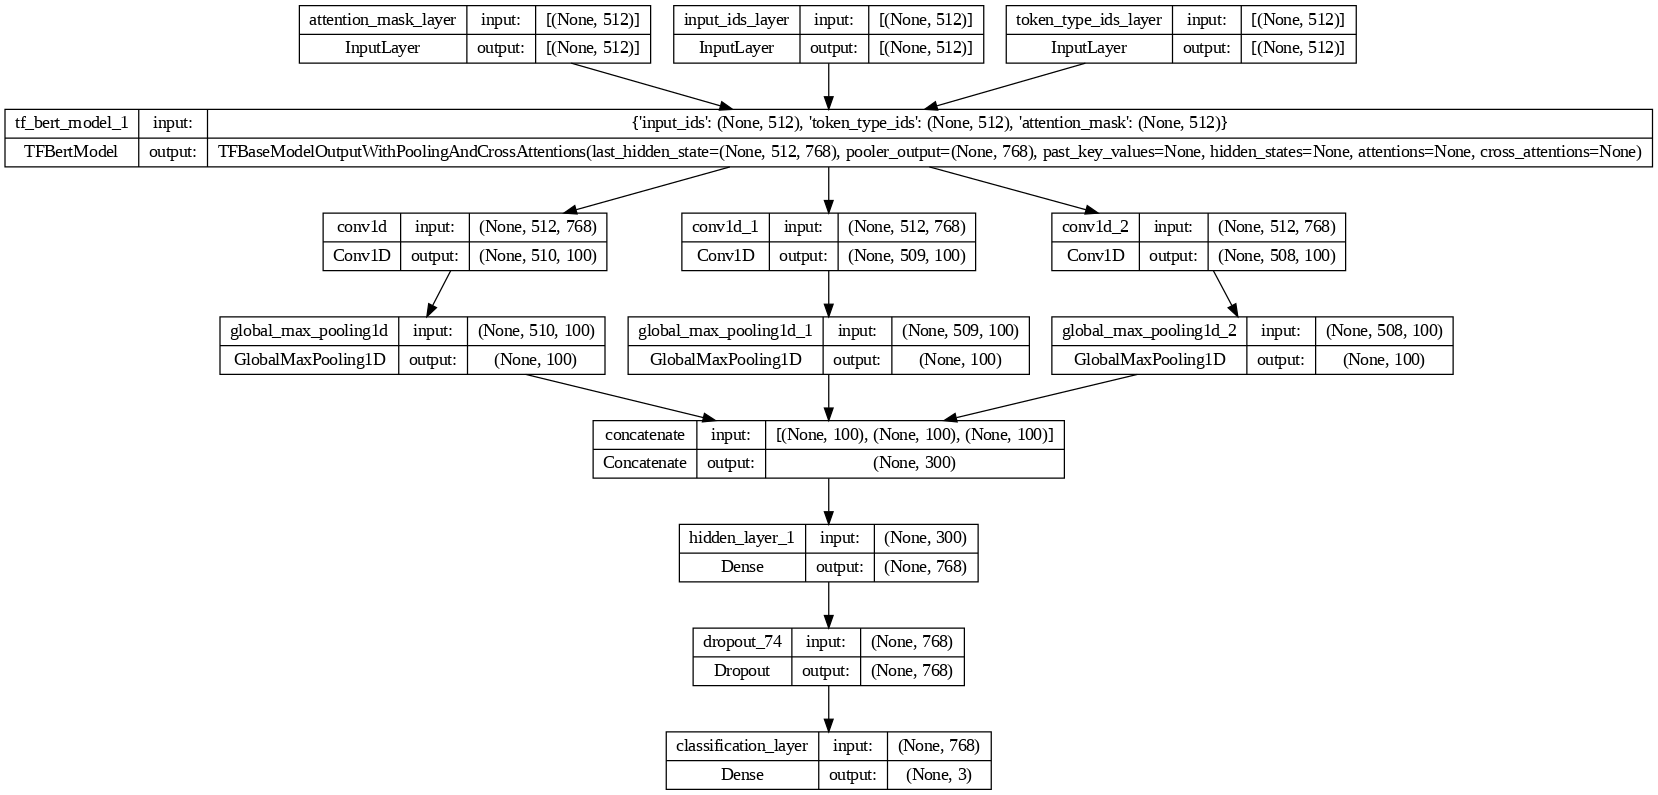

In [16]:
keras.utils.plot_model(bert_classification_model, show_shapes=True, dpi=90)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
# Early stopping callback to avoid overfitting issue
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=1,
    mode='max',
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [18]:
bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_validate.input_ids, x_validate.token_type_ids, x_validate.attention_mask], y_validate),
    batch_size=16,
    epochs=5
)

Epoch 1/5


145/145 [==============================] - 215s 1s/step - loss: 1.1178 - accuracy: 0.4071 - val_loss: 1.0680 - val_accuracy: 0.4450
Epoch 2/5
145/145 [==============================] - 168s 1s/step - loss: 1.0458 - accuracy: 0.4775 - val_loss: 0.9315 - val_accuracy: 0.5200
Epoch 3/5
145/145 [==============================] - 168s 1s/step - loss: 0.8199 - accuracy: 0.6124 - val_loss: 0.6360 - val_accuracy: 0.7250
Epoch 4/5
145/145 [==============================] - 168s 1s/step - loss: 0.6514 - accuracy: 0.7152 - val_loss: 0.5159 - val_accuracy: 0.8100
Epoch 5/5
145/145 [==============================] - 168s 1s/step - loss: 0.4492 - accuracy: 0.8237 - val_loss: 0.3726 - val_accuracy: 0.8450


In [ ]:
# bert_classification_model_history = bert_classification_model.fit(
#     [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
#     y_train,
#     validation_data=([x_validate.input_ids, x_validate.token_type_ids, x_validate.attention_mask], y_validate),
#     batch_size=32,
#     epochs=4,
#     callbacks=[early_stopping]
# )

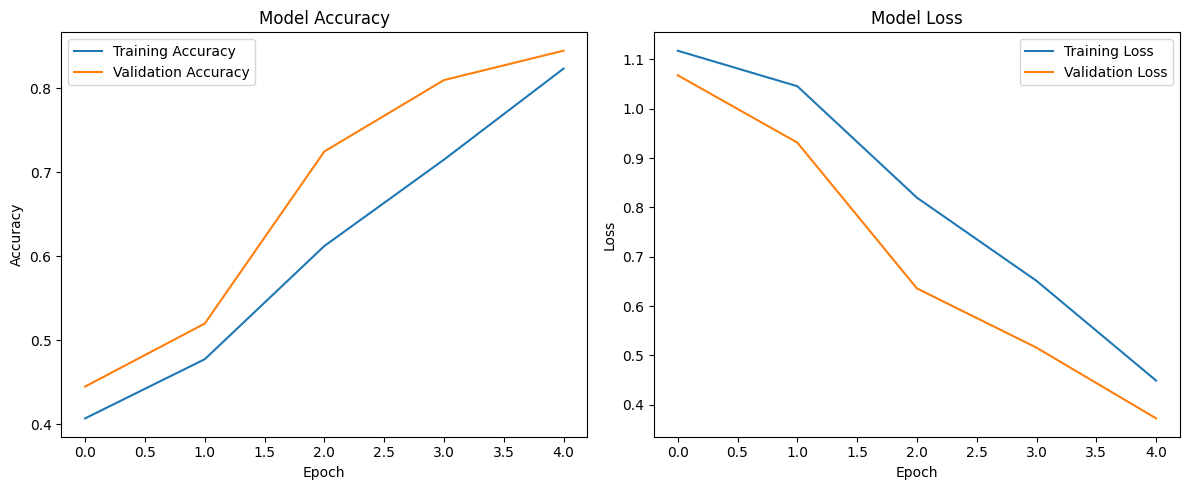

In [19]:
history = bert_classification_model_history.history

# Plotting accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1,2,2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
#Fine-Tuned BERT model overall prediction score
score = bert_classification_model.evaluate([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask],
                                                  y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

12/12 [==============================] - 10s 775ms/step - loss: 0.4279 - accuracy: 0.8338
Test loss: 0.42785564064979553
Test accuracy: 0.8337730765342712


In [21]:
predictions_model= bert_classification_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
predictions_model = tf.argmax(predictions_model, axis=-1)
predictions_model

12/12 [==============================] - 11s 714ms/step


<tf.Tensor: shape=(379,), dtype=int64, numpy=
array([0, 1, 2, 2, 0, 2, 0, 0, 1, 2, 2, 2, 1, 2, 0, 0, 2, 1, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 1, 2, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 2, 2,
       0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 1, 0,
       2, 0, 2, 0, 0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 0, 1, 0, 2, 2, 1, 1,
       0, 2, 1, 1, 0, 1, 1, 2, 2, 2, 2, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 2,
       0, 1, 2, 1, 2, 0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 2, 1, 1, 0, 0, 1, 2,
       2, 1, 1, 2, 0, 2, 0, 2, 1, 0, 0, 1, 0, 2, 0, 0, 1, 2, 2, 2, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2,
       2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 1, 1, 1, 1, 0, 2, 2,
       2, 0, 0, 2, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 2, 0, 0, 0, 2, 1, 2, 1, 1, 0, 0, 1, 0, 0, 0, 2, 2, 1,
       2, 2, 0, 0, 0, 0, 2, 1, 1, 0, 2, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2,
     

In [22]:
print(classification_report(y_test, predictions_model.numpy(),
                            target_names=['Left ','Center','Right']))

              precision    recall  f1-score   support

       Left        0.84      0.89      0.86       174
      Center       0.86      0.81      0.83        88
       Right       0.81      0.78      0.79       117

    accuracy                           0.83       379
   macro avg       0.83      0.82      0.83       379
weighted avg       0.83      0.83      0.83       379



In [23]:
def plot_confusion_matrix(y_true, y_pred, label_names):
    cm = tf.math.confusion_matrix(y_true, y_pred)
    cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

    plt.figure(figsize=(20,7))
    sns.heatmap(
        cm, annot=True,
        xticklabels=label_names,
        yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")

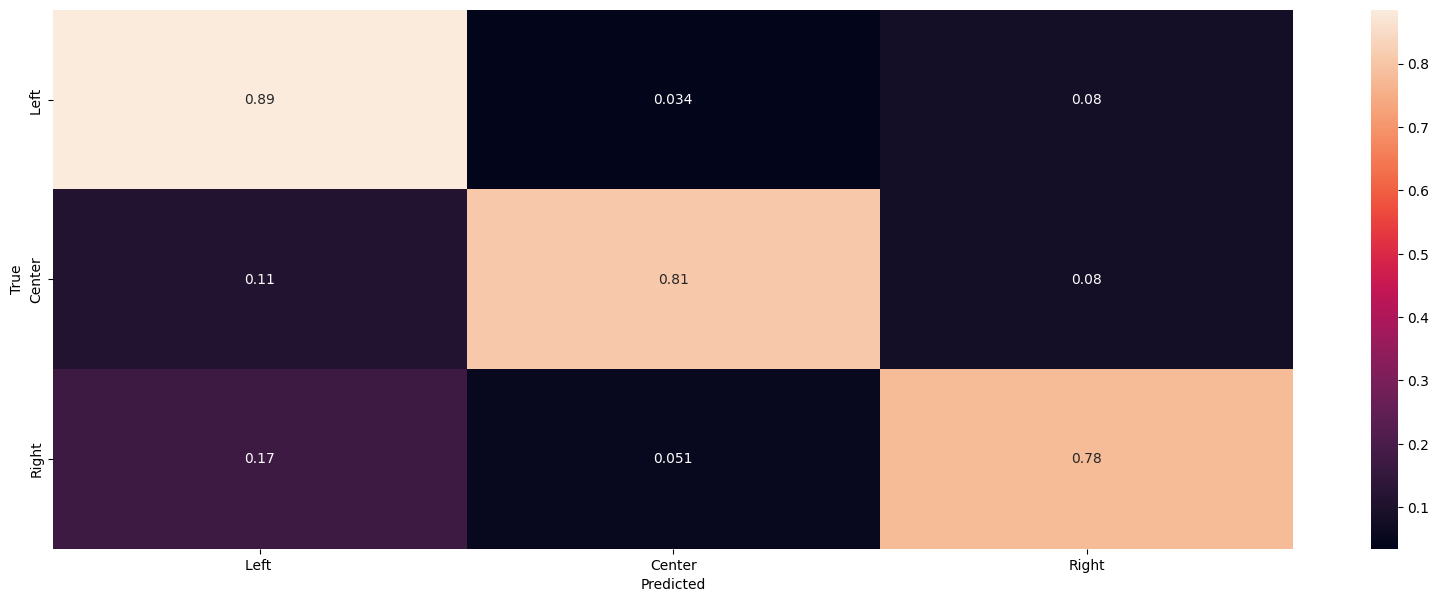

In [24]:
target_names=['Left ','Center','Right']
plot_confusion_matrix(y_test, predictions_model.numpy(), target_names)

In [25]:
bert_wrong_guesses = np.where(y_test != predictions_model.numpy())

In [27]:
print(f'Number of Wrong Guesses: ',len(bert_wrong_guesses[0]))

Number of Wrong Guesses:  63


In [28]:
#sampling 20 of the wrong precditions
wrong_guesses = [i for i in np.squeeze(bert_wrong_guesses[0])]
decoded_wrong_guesses_text=[]

for i in wrong_guesses[:]:
  decoded_text = bert_tokenizer.decode(x_test['input_ids'][i], skip_special_tokens=True)

  # print("Input text:")
  # print(decoded_text)
  decoded_wrong_guesses_text.append(decoded_text)
  # print("True label:")
  # print(y_test.iloc[i])
  # print("Predicted label:")
  # print(predictions_model.numpy()[i])

  # print("-" * 50)



In [29]:
len(decoded_wrong_guesses_text)

63

In [30]:
sources_analysis = test_df.loc[wrong_guesses]

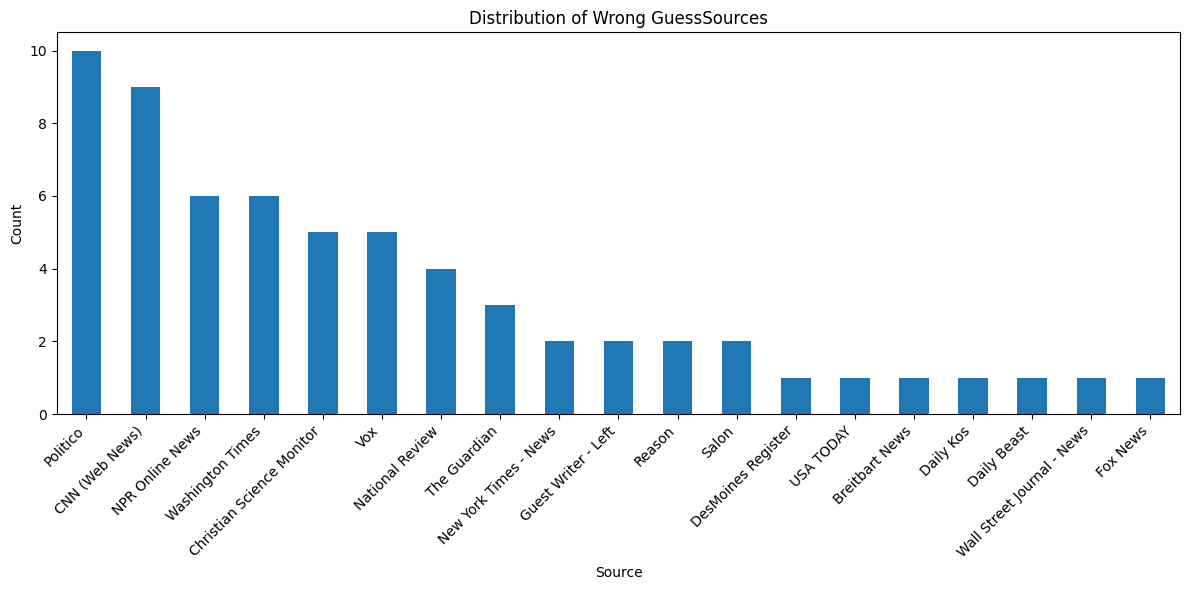

In [31]:
sources_analysis['source']
# Count the occurrences of each source
source_counts = sources_analysis['source'].value_counts()

# Create a bar plot
plt.figure(figsize=(12, 6))
source_counts.plot(kind='bar')

# Customize the plot
plt.title('Distribution of Wrong Guess''Sources')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

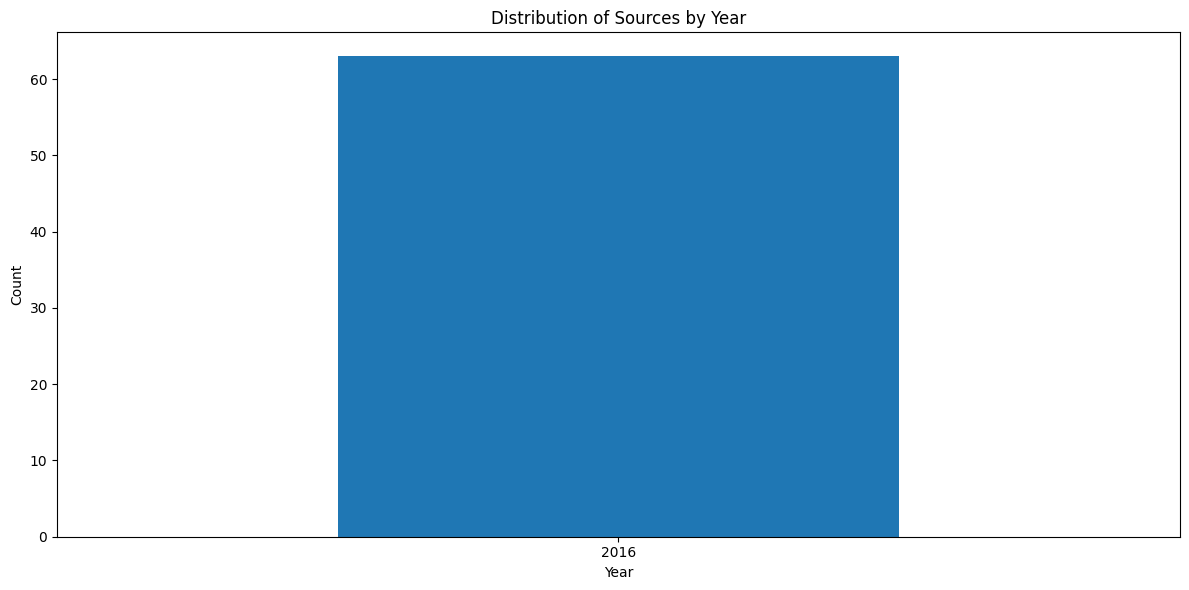

In [32]:
# Convert 'date' to datetime if it's not already
sources_analysis['date'] = pd.to_datetime(sources_analysis['date'])

# Extract year from the date
sources_analysis['year'] = sources_analysis['date'].dt.year

# Count occurrences of each year
year_counts = sources_analysis['year'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar')

# Customize the plot
plt.title('Distribution of Sources by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)  # No rotation for years
plt.tight_layout()

# Show the plot
plt.show()

In [33]:
for i in wrong_guesses[:50]:
  decoded_text = bert_tokenizer.decode(x_test['input_ids'][i], skip_special_tokens=True)

  print("Input text:")
  print(decoded_text)
  print("True label:")
  print(y_test.iloc[i])
  print("Predicted label:")
  print(predictions_model.numpy()[i])

  print("-" * 50)


Input text:
we ’ ve before. alarm clock sound it ’ s another biased debate presided supposed neutral ” media. yes, groundhog day ” debate tuesday night longwood university. that ’ s cbs anchor debate moderator elaine quijano best lester holt impersonation ( or candy crowley maybe cnbc ) – throwing hard question mostly republican gov. mike penny allowing sen. tim kaine interrupt will. quijano turned left first question – citing 1988 liberal, democratic vice presidential candidate lloyd bentsen ’ s comment responsibility vice president. recalled said, tragedy occur, vice president step without margin error. ” set stage perfectly signaled viewer debate seen consistently left. quijano didn ’ t disappoint. by factor 8to1, quijano peppered penny tough question tough question. reserved one kaine. for conservatives, like groundhog day. viewer saw shadow, mean slightly one month mostbiased medium election human history. by factor 8to1, quijano peppered penny tough question tough question. reser

In [34]:
sources_analysis.to_csv('bert_fine_tuning_wrong guess(7.21.24).csv', index=False)